# Задание: Классифицировать по тональности отзывы на банки с сайта banki.ru
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:57, 3518.36it/s]


## 1. Анализ текста

### 1.1. Посчитайте количество отзывов в разных городах и на разные банки

Разбираемся в структуре даннных:

In [6]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [7]:
responses[0].get('city')

'г. Москва'

In [8]:
len(responses) #всего отзывов

153499

In [13]:
cities = [] #в один блок не получалось прогнать, на память ругался
for i in responses[0:100000]:
    cities.append(i.get('city'))

In [15]:
for i in responses[100000:153499]:
    cities.append(i.get('city'))
print(len(cities))

153499


In [17]:
cities[0:10]

['г. Москва',
 'г. Новосибирск',
 'г. Москва',
 'г. Ставрополь',
 'г. Челябинск',
 'г. Москва',
 'г. Волгоград',
 'г. Москва',
 'г. Пермь',
 'г. Ростов-на-Дону']

In [19]:
num_cities = {}
count = 1
for i in cities:
    if num_cities.get(i, False) is False:
        count = 1
        num_cities[i] = count # добавляем его и помещает туда список с одним значением
    else:  # если такой ключ уже есть
        count = num_cities.get(i) 
        count = count+1
        num_cities[i] = count  # добавляем счетчик
#print(num_cities)

In [21]:
num_cities.get('г. Москва')

55354

In [25]:
sorted_cities = sorted(num_cities.items(), reverse=True, key=lambda item: item[1])
sorted_cities[0:20]

[('г. Москва', 55354),
 (None, 15174),
 ('г. Санкт-Петербург', 14342),
 ('г. Екатеринбург', 2337),
 ('г. Новосибирск', 2300),
 ('г. Нижний Новгород', 1976),
 ('г. Ростов-на-Дону', 1891),
 ('г. Самара', 1731),
 ('г. Челябинск', 1507),
 ('г. Казань', 1440),
 ('г. Краснодар', 1262),
 ('г. Уфа', 1246),
 ('г. Красноярск', 1236),
 ('г. москва', 1217),
 ('г. Воронеж', 1210),
 ('г. Пермь', 1163),
 ('г. Волгоград', 1014),
 ('г. Омск', 989),
 ('г. Саратов', 933),
 ('г. Иркутск', 749)]

Больше всего отзывов из Москвы (55354), без названия города (15174), и из Санкт-Петербурга. 

Можно было бы ещё привести всё к нижнему регистру и посчитать так, или проверять вхождение Москва в строку.

То же самое для банков:

In [27]:
banks = [] #в один блок не получалось прогнать, на память ругался
for i in responses:
    banks.append(i.get('bank_name'))

In [29]:
num_banks = {}
count = 1
for i in banks:
    if num_banks.get(i, False) is False:
        count = 1
        num_banks[i] = count # добавляем его и помещает туда список с одним значением
    else:  # если такой ключ уже есть
        count = num_banks.get(i) 
        count = count+1
        num_banks[i] = count  # добавляем счетчик
#print(num_cities)

In [33]:
sorted_banks = sorted(num_banks.items(), reverse=True, key=lambda item: item[1])
sorted_banks[0:20]

[('Сбербанк России', 26327),
 ('Альфа-Банк', 10224),
 ('ВТБ 24', 8185),
 ('Русский Стандарт', 7943),
 ('Хоум Кредит Банк', 7549),
 ('Тинькофф Банк', 5387),
 ('Национальный Банк «Траст»', 4607),
 ('Ренессанс Кредит', 3849),
 ('Связной Банк', 3775),
 ('ОТП Банк', 3237),
 ('Восточный Экспресс Банк', 3138),
 ('Райффайзенбанк', 3057),
 ('Московский Кредитный Банк', 2944),
 ('Ситибанк', 2848),
 ('Авангард', 2733),
 ('Промсвязьбанк', 2586),
 ('ЮниКредит Банк', 2488),
 ('Банк Москвы', 2456),
 ('Ханты-Мансийский банк Открытие', 2158),
 ('МТС Банк', 1870)]

Больше всего отзывов на Сбербанк (26327) и Альфа-Банк (10224). Видимо банки пользователи выбирают из списка, так как нет опечаток и разных написаний одного и того же банка.

### 1.2. Постройте гистограмы длин слов в символах и в словах

##### Посчитаем количество символов в словах.

Сначала для одного текста:

In [7]:
responses[0].get('text') 

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [9]:
lst = responses[0].get('text').replace('.', '').split() #разделим текст на слова по пробелам

In [10]:
count_words = [] #каждое слово заменяем его длиной
for i in lst:
    count_words.append(len(i))

Гистограмма длин слов для одного текста:

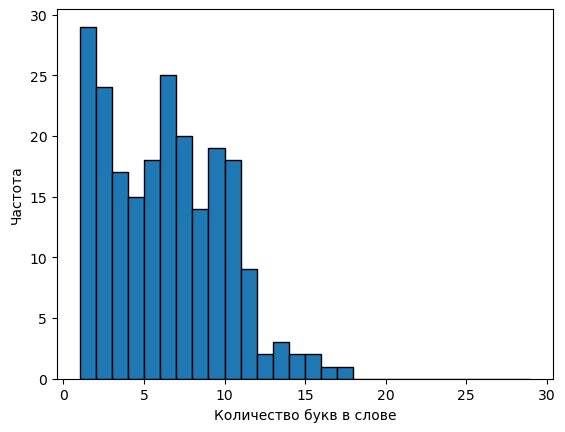

In [10]:
import matplotlib.pyplot as plt

# Данные
data = count_words

# Построение гистограммы
plt.hist(data, bins=range(1, 30), edgecolor='black')
plt.xlabel('Количество букв в слове')
plt.ylabel('Частота')
plt.show()

Гистограмма длин слов всех текстов:

In [11]:
texts = [] #слепливаем один список все тексты
for i in responses:
    texts.append(i.get('text'))
len(texts)

153499

In [15]:
texts[0]

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [12]:
import re
clean_texts_test = re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', texts[0])
clean_texts_test

'Добрый день Я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  Начиная с марта  года начали приходить бесконечные письма из ООО Примо коллектна мой адрес город Москва Уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года Со всей ответственностью хочу Вас заверить что вышеуказанный гражданин которого Вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по Вашей милости я должна переживать и бояться за себе и свое имущество Письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зак

In [13]:
giga_text = ' '.join(texts) #слепливаем в один гига текст все элементы списка

In [55]:
len(giga_text) #количество символов в тексте

238723607

In [57]:
import re #почистим текст, избавимся от всего кроме букв
clean_texts = re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', giga_text)

In [161]:
len(clean_texts)

225648783

In [163]:
lst = clean_texts.replace('.', '').split() #разделяем текст на список по пробелам

In [165]:
len(lst)

35020379

In [167]:
count_words = [] #каждое слово заменяем его длиной
for i in lst:
    count_words.append(len(i))

In [169]:
len(count_words)

35020379

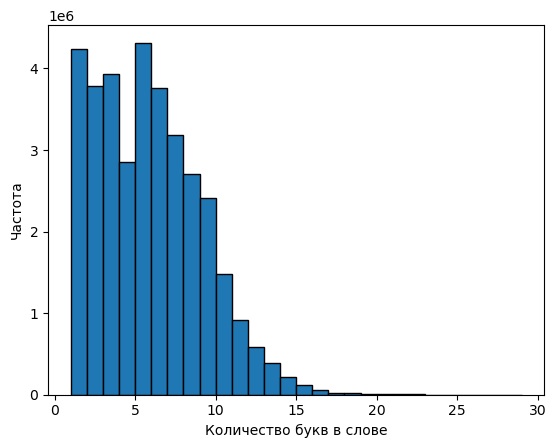

In [171]:
import matplotlib.pyplot as plt

# Данные
data = count_words

# Построение гистограммы
plt.hist(data, bins=range(1, 30), edgecolor='black')
plt.xlabel('Количество букв в слове')
plt.ylabel('Частота')
plt.show()

##### Вторую гистограмму построю по количеству слов в одном отзыве:

In [ ]:
#проходимся циклом по всем отзывам, каждый отзыв делим на слова, затем вместо отзыва целиком записываем число слов в список

In [94]:
texts = [] #слепливаем один список все тексты
for i in responses:
    texts.append(i.get('text'))
len(texts)

153499

In [102]:
review_lenght = [] #в texts с прошлой гистограммы уже лежат все тексты отзывов из начального словаря
for i in texts:
    review_lenght.append(len(i))

In [106]:
len(review_lenght)

153499

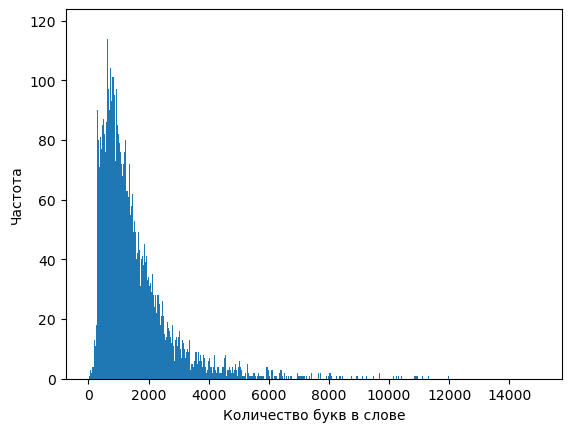

In [116]:
# Данные
data = review_lenght

# Построение гистограммы
plt.hist(data, bins=range(1, 15000))
plt.xlabel('Количество букв в слове')
plt.ylabel('Частота')
plt.show()

### 1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных

##### Наиболее частые слова

Для одного текста:

In [11]:
clean_text = re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', responses[0].get('text'))

In [12]:
lst = clean_text.replace('.', '').split() #разделим текст на слова по пробелам
lst[0:5]

['Добрый', 'день', 'Я', 'не', 'являюсь']

In [13]:
from collections import Counter

my_list = lst
most_common_element = Counter(my_list).most_common(10)#[0][0]

print(most_common_element)

[('не', 7), ('и', 7), ('в', 6), ('по', 5), ('с', 5), ('мне', 4), ('года', 3), ('от', 3), ('договор', 3), ('на', 3)]


Для всех текстов:

In [138]:
lst = giga_text.replace('.', '').split() #разделяем текст на список по пробелам

In [143]:
my_list = lst
most_common_element = Counter(my_list).most_common(10)#[0][0]

print(most_common_element)

[('в', 1157361), ('и', 966959), ('не', 808432), ('на', 632628), ('что', 587842), ('я', 430225), ('с', 423726), ('по', 333356), ('-', 294105), ('мне', 279398)]


##### Наиболее частые слова без стоп-слов (и без знаков препинания, и всё приведено к нижнему регистру)

In [23]:
clean_texts = re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', giga_text)

In [24]:
clean_texts = clean_texts.lower()

In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

text = clean_texts
tokens = word_tokenize(text)
stop_words = set(stopwords.words('russian'))
filtered_tokens = [word for word in tokens if word not in stop_words]

In [34]:
filtered_tokens[0:5]

['добрый', 'день', 'являюсь', 'клиентом', 'банка']

In [42]:
from collections import Counter
my_list = filtered_tokens
most_common_element = Counter(my_list).most_common#[0][0]

print(most_common_element(10))

[('банка', 263827), ('банк', 196235), ('это', 183007), ('деньги', 130040), ('карту', 104929), ('карты', 100872), ('кредит', 80212), ('день', 75984), ('заявление', 69499), ('отделение', 66450)]


##### Наиболее частые слова после лемматизации

In [44]:
from pymorphy3 import MorphAnalyzer

In [134]:
morph = MorphAnalyzer()

In [136]:
lemmas = [] #получаю леммы всего текста
for token in filtered_tokens:
    lemmas.append(morph.normal_forms(token)[0])

In [137]:
my_list = lemmas
most_common_element = Counter(my_list).most_common#[0][0]

print(most_common_element(10))

[('банк', 624062), ('карта', 331778), ('это', 199689), ('деньга', 178322), ('день', 172195), ('мой', 161053), ('кредит', 154772), ('который', 148785), ('отделение', 143574), ('сотрудник', 133561)]


##### Наиболее частые существительные:

Для одного текста:

In [1144]:
from pymystem3 import Mystem #ставим библиотику, разбираемся как она работает
mystem = Mystem()
text = 'лес'
speech_part = mystem.analyze(text)
print(speech_part)
print(speech_part[0])
print(speech_part[0].get('analysis'))
print(speech_part[0].get('analysis')[0].get('gr')[0])

[{'analysis': [{'lex': 'лес', 'wt': 0.9992945031, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}], 'text': 'лес'}, {'text': '\n'}]
{'analysis': [{'lex': 'лес', 'wt': 0.9992945031, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}], 'text': 'лес'}
[{'lex': 'лес', 'wt': 0.9992945031, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}]
S


In [107]:
clean_texts = re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', texts[0]) 

In [109]:
clean_texts = clean_texts.lower()

In [111]:
#приводим к начальной форме
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

text = clean_texts
tokens = word_tokenize(text)
stop_words = set(stopwords.words('russian'))
filtered_tokens = [word for word in tokens if word not in stop_words]

In [113]:
filtered_tokens[0:5]

['добрый', 'день', 'являюсь', 'клиентом', 'банка']

In [115]:
lemmas = [] #получаю леммы одного текста
for token in filtered_tokens:
    lemmas.append(morph.normal_forms(token)[0])

In [117]:
lemmas[0:5]

['добрый', 'день', 'являться', 'клиент', 'банк']

In [119]:
speech_part_test = []
for i in lemmas:
#    print(i)
#    print(mystem.analyze(i))
#    print(mystem.analyze(i)[0].get('analysis')[0].get('gr')[0])
    if mystem.analyze(i)[0].get('analysis')[0].get('gr')[0] == 'S':
        speech_part_test.append(i)

In [125]:
from collections import Counter
my_list = speech_part_test
most_common_element = Counter(my_list).most_common(10)#[0][0]

print('Самые популярные слова в первом тексте:', most_common_element)

Самые популярные слова в первом тексте: [('договор', 4), ('банк', 3), ('отношение', 3), ('год', 3), ('письмо', 3), ('адрес', 3), ('угроза', 2), ('гражданин', 2), ('вопрос', 2), ('заявление', 2)]


__________________
Для 50 текстов:

In [1258]:
mystem = Mystem()

In [1260]:
responses_for_nouns = responses[0:500]

In [1262]:
print(responses[0])

{'city': 'г. Москва', 'rating_not_checked': False, 'title': 'Жалоба', 'num_comments': 0, 'bank_license': 'лицензия № 2562', 'author': 'uhnov1', 'bank_name': 'Бинбанк', 'datetime': '2015-06-08 12:50:54', 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверив

In [1264]:
texts_for_nouns = []
for i in responses_for_nouns:
    texts_for_nouns.append(i.get('text'))
print(texts_for_nouns[0])

Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью  хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,  и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мне серье

In [1266]:
clean_texts_for_nouns = []
for i in texts_for_nouns:
    clean_texts_for_nouns.append(re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', i))
print(clean_texts_for_nouns[0])

Добрый день Я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  Начиная с марта  года начали приходить бесконечные письма из ООО Примо коллектна мой адрес город Москва Уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года Со всей ответственностью хочу Вас заверить что вышеуказанный гражданин которого Вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по Вашей милости я должна переживать и бояться за себе и свое имущество Письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зако

In [1268]:
clean_texts_for_nouns_lower = []
for i in clean_texts_for_nouns:
    clean_texts_for_nouns_lower.append(i.lower())
print(clean_texts_for_nouns_lower[0])

добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  начиная с марта  года начали приходить бесконечные письма из ооо примо коллектна мой адрес город москва уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зако

In [1270]:
giga_text_for_nouns = ' '.join(clean_texts_for_nouns_lower)

In [1272]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

text = giga_text_for_nouns #чистим от стоп-слов
tokens = word_tokenize(text)
stop_words = set(stopwords.words('russian'))
filtered_tokens = [word for word in tokens if word not in stop_words]

In [1274]:
filtered_tokens[0:5]

['добрый', 'день', 'являюсь', 'клиентом', 'банка']

In [1276]:
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

lemmas = [] #получаю леммы одного текста
for token in filtered_tokens:
    lemmas.append(morph.normal_forms(token)[0])

In [1278]:
print(lemmas[0:5])
len(lemmas)

['добрый', 'день', 'являться', 'клиент', 'банк']


58040

In [ ]:
speech_part_test = []
for i in lemmas:
    try:
        if mystem.analyze(i)[0].get('analysis')[0].get('gr')[0] == 'S':
            speech_part_test.append(i)
    except IndexError:
        pass

In [1194]:
speech_part_test = [] #оставляем только существительные, здесь вылетает ошибка если не перезапустить файл, плюс иногда он не находит вообще часть речи, и это тоже ошибка
try:
    for i in lemmas:
        if mystem.analyze(i)[0].get('analysis')[0].get('gr')[0] == 'S':
            speech_part_test.append(i)
except:
    pass

In [1252]:
my_list = speech_part_test
most_common_element = Counter(my_list).most_common(len(my_list))#[0][0] #здесь надо докрутить, в most_common_element 
#будет храниться весь список всего, в принте надо вывести 10 самых популярных

In [1254]:
print(most_common_element)

[('банк', 7), ('карта', 7), ('руб', 5), ('договор', 4), ('год', 4), ('документ', 4), ('заявление', 4), ('фамилия', 4), ('отношение', 3), ('письмо', 3), ('адрес', 3), ('сбербанк', 3), ('токарев', 3), ('секлетина', 3), ('ситуация', 3), ('день', 2), ('клиент', 2), ('угроза', 2), ('гражданин', 2), ('вопрос', 2), ('копия', 2), ('паспорт', 2), ('свидетельство', 2), ('брак', 2), ('мария', 2), ('александрович', 2), ('база', 2), ('уважение', 2), ('интернетмагазин', 2), ('сумма', 2), ('поручитель', 1), ('какимлибо', 1), ('лицо', 1), ('повод', 1), ('урегулирование', 1), ('чьейлибо', 1), ('задолженность', 1), ('март', 1), ('ооо', 1), ('город', 1), ('москва', 1), ('переулок', 1), ('дом', 1), ('квартира', 1), ('возбуждение', 1), ('дело', 1), ('филиппов', 1), ('эдуард', 1), ('владимирович', 1), ('уплата', 1), ('кредит', 1), ('ответственность', 1), ('знак', 1), ('образ', 1), ('подлинность', 1), ('имя', 1), ('мера', 1), ('милость', 1), ('имущество', 1), ('неудобство', 1), ('право', 1), ('закон', 1), ('

In [1256]:
print(most_common_element[0:10])

[('банк', 7), ('карта', 7), ('руб', 5), ('договор', 4), ('год', 4), ('документ', 4), ('заявление', 4), ('фамилия', 4), ('отношение', 3), ('письмо', 3)]


### 1.4. Постройте кривые Ципфа и Хипса

#### Кривая Ципфа
Если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-ного слова обратно пропорциональна его порядковому номеру

Для одного текста:

In [99]:
most_common_element_one_text = Counter(my_list).most_common(len(my_list))
most_common_element_one_text[0:5]

[('договор', 4), ('банк', 3), ('отношение', 3), ('год', 3), ('письмо', 3)]

In [105]:
counter_ = []
for i in most_common_element_one_text:
    counter_.append(i[1])
counter_[0:5]

[4, 3, 3, 3, 3]

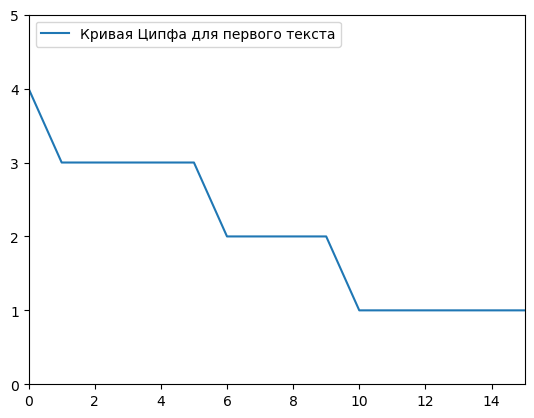

In [112]:
data = {'Кривая Ципфа для первого текста':counter_}
df = pd.DataFrame(data)
x = np.arange(len(counter_))
plt.axis([0,15,0,5])
plt.plot(x,df)
plt.legend(data, loc=2)
plt.show()

_________________
Для 2000 текстов:

In [129]:
counter_ = []
for i in most_common_element(2000):
    counter_.append(i[1])
len(counter_)

2000

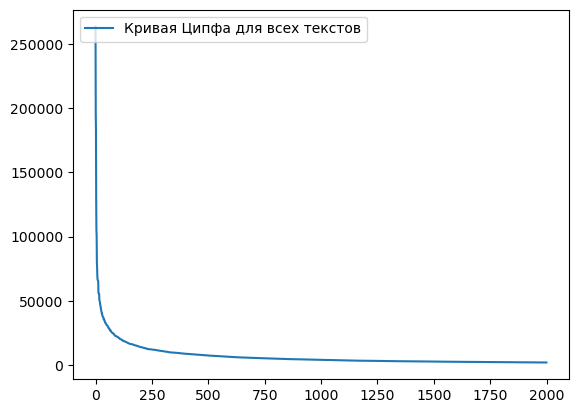

In [131]:
data = {'Кривая Ципфа для всех текстов':counter_}
df = pd.DataFrame(data)
x = np.arange(len(counter_))
#plt.axis([0,100,0,100])
plt.plot(x,df)
plt.legend(data, loc=2)
plt.show()

________________

#### Кривая Хипса
Чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

In [ ]:
#в цикле считаем размер первого текста - кол-во новых слов, размер первого+второго текста - кол-во новых слов и т.д
#получается два списка, в одном записано с увеличением количество слов всего, во втором записано на сколько увеличилось
#уникальных слов
#в матплотлиб соответственно оба списка передаём и всё

In [238]:
###предобработка###
responses_for_hipsa = responses[0:5000] #я устала ждать когда построится для всех текстов и возьму первые 5000

In [240]:
texts_for_hipsa = []
for i in responses_for_hipsa:
    texts_for_hipsa.append(i.get('text'))

In [242]:
clean_texts_for_hipsa = []
for i in texts_for_hipsa:
    clean_texts_for_hipsa.append(re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', i))

In [244]:
clean_texts_for_hipsa_lower = []
for i in clean_texts_for_hipsa:
    clean_texts_for_hipsa_lower.append(i.lower())

In [246]:
clean_texts_for_hipsa_lower[0]
###конец предобработки###

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  начиная с марта  года начали приходить бесконечные письма из ооо примо коллектна мой адрес город москва уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зак

In [248]:
#функция для подсчёта сколько слов в тех текстах которые подгружают, передаётся список с текстами, возвращается список
#с постепенно увеличивающимся количеством слов
def count_of_all_texts_hips(text):

    size_of_texts = []
    size_of_all_texts = 0

    for i in text:
        lst = clean_texts_for_hipsa_lower[1].replace('.', '').split()
        size_of_local_text = len(lst)
        size_of_all_texts = size_of_all_texts+size_of_local_text
        size_of_texts.append(size_of_all_texts)
        
    return size_of_texts

In [250]:
#функция для подсчета уникальных слов, добавляющихся с каждым новым текстом
def unique_words_hips(text):
    unique_words = []
    unique_words_count = []
    for i in text:
        lst = i.replace('.', '').split()
        for i in lst:
            if i not in unique_words:
                unique_words.append(i)  
        unique_words_count_local_text = len(unique_words)
        unique_words_count.append(unique_words_count_local_text)
            
    return unique_words_count

Кривая Хипса для 5000 текстов:

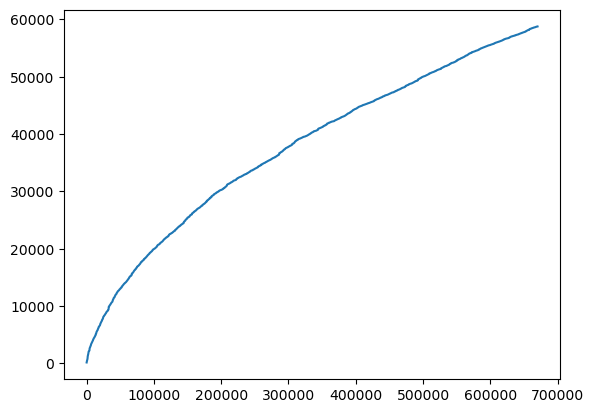

In [252]:
x = count_of_all_texts_hips(clean_texts_for_hipsa_lower)
y = unique_words_hips(clean_texts_for_hipsa_lower)
plt.plot(x, y)
plt.show()

## 1.5 Ответьте на вопросы: какое слово встречается чаще, "сотрудник" или "клиент", сколько раз встречается слова "мошенничество" и "доверие"?

In [142]:
item = 'сотрудник' 
for i in most_common_element(3000):
    try:
        index = i.index(item)
        print(f"слово {item} встречается {i[1]} раз")
    except ValueError:
        pass

слово сотрудник встречается 133561 раз


In [144]:
item = 'клиент'
for i in most_common_element(3000):
    try:
        index = i.index(item)
        print(f"слово {item} встречается {i[1]} раз")
    except ValueError:
        pass

слово клиент встречается 132891 раз


Слово "сотрудник" встречается чаще.

In [147]:
item = 'мошенничество' 
for i in most_common_element(3000):
    try:
        index = i.index(item)
        print(f"слово {item} встречается {i[1]} раз")
    except ValueError:
        pass

слово мошенничество встречается 3221 раз


In [150]:
item = 'доверие'
for i in most_common_element(3000):
    try:
        index = i.index(item)
        print(f"слово {item} встречается {i[1]} раз")
    except ValueError:
        pass

слово доверие встречается 2101 раз


## 1.6 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  𝑡𝑓−𝑖𝑑𝑓, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

TF-IDF - статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

TF (Term Frequency) измеряет, как часто слово встречается в документе.

IDF (Inverse Document Frequency) оценивает, насколько слово уникально для данного документа по сравнению с другими документами в корпусе.

Перед применением TF-IDF необходимо провести предварительную обработку текста: токенизация, удаление стоп-слов и приведение слов к нижнему регистру.

In [ ]:
#логика: сначала оставляем только отзывы на 1 и на 5, затем уже для каждого отзыва в этих двух разных списках считаем меру

In [38]:
responses[1]

{'city': 'г. Новосибирск',
 'rating_not_checked': False,
 'title': 'Не могу пользоваться услугой Сбербанк он-лайн',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'Foryou',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-08 11:09:57',
 'text': 'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня про

In [156]:
grade_1 = [] #фильтруем отзывы с оценкой 1
for i in responses:
    if i.get('rating_grade') == 1:
        grade_1.append(i.get('text'))

In [158]:
len(grade_1)

47387

47 387 отзывов с оценкой 1

In [161]:
grade_5 = [] #фильтруем отзывы с оценкой 5
for i in responses:
    if i.get('rating_grade') == 5:
        grade_5.append(i.get('text'))

In [163]:
len(grade_5)

14713

In [43]:
grade_5[0]

'Досрочно закрывали вклады перед отпуском. Жена заказывала заранее, но забыла заказать на меня. Сотрудник банка (СПБ Ленсовета 89) Наталья не отказала мне, хотя сумма значительная. Работает быстро, профессионально. Ничего лишнего. Жаль, что прикрыли прием вкладов в офисе Озерки - доступность офиса для меня. Заметил, что и несут деньги во вклады и берут кредиты. Желаю успехов банку.'

14 713 отзывов с оценкой 5

##### TF-idf для оценки 5 для первых трёх текстов:

In [200]:
### предобработка ###
grade_5_clean = []
for i in grade_5[0:3]:
    grade_5_clean.append(re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', i))
grade_5_clean[0]

'Досрочно закрывали вклады перед отпуском Жена заказывала заранее но забыла заказать на меня Сотрудник банка СПБ Ленсовета  Наталья не отказала мне хотя сумма значительная Работает быстро профессионально Ничего лишнего Жаль что прикрыли прием вкладов в офисе Озерки  доступность офиса для меня Заметил что и несут деньги во вклады и берут кредиты Желаю успехов банку'

In [202]:
grade_5_clean_lower = []
for i in grade_5_clean:
    grade_5_clean_lower.append(i.lower())
grade_5_clean_lower[0]

'досрочно закрывали вклады перед отпуском жена заказывала заранее но забыла заказать на меня сотрудник банка спб ленсовета  наталья не отказала мне хотя сумма значительная работает быстро профессионально ничего лишнего жаль что прикрыли прием вкладов в офисе озерки  доступность офиса для меня заметил что и несут деньги во вклады и берут кредиты желаю успехов банку'

In [204]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
grade_5_list = []

for i in grade_5_clean_lower:
    now_list = []
    text = i
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    grade_5_list.append(filtered_tokens)
print(grade_5_list[0])

['досрочно', 'закрывали', 'вклады', 'отпуском', 'жена', 'заказывала', 'заранее', 'забыла', 'заказать', 'сотрудник', 'банка', 'спб', 'ленсовета', 'наталья', 'отказала', 'хотя', 'сумма', 'значительная', 'работает', 'быстро', 'профессионально', 'лишнего', 'жаль', 'прикрыли', 'прием', 'вкладов', 'офисе', 'озерки', 'доступность', 'офиса', 'заметил', 'несут', 'деньги', 'вклады', 'берут', 'кредиты', 'желаю', 'успехов', 'банку']


In [206]:
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()

grade_5_lemmas = [] #получаю леммы всего текста
for text in grade_5_list:
    now_list = []
    for token in text:
        now_list.append(morph.normal_forms(token)[0])
    grade_5_lemmas.append(now_list)

print(grade_5_lemmas)

[['досрочно', 'закрывать', 'вклад', 'отпуск', 'жена', 'заказывать', 'заранее', 'забыть', 'заказать', 'сотрудник', 'банк', 'спб', 'ленсовет', 'наталья', 'отказать', 'хотя', 'сумма', 'значительный', 'работать', 'быстро', 'профессионально', 'лишний', 'жаль', 'прикрыть', 'приём', 'вклад', 'офис', 'озерко', 'доступность', 'офис', 'заметить', 'нести', 'деньга', 'вклад', 'брать', 'кредит', 'желать', 'успех', 'банк'], ['хотеть', 'открыть', 'вклад', 'доходный', 'год', 'процент', 'начисляться', 'лесенка', 'месяц', 'месяц', 'месяц', 'условие', 'общий', 'объём', 'дополнительный', 'взнос', 'превышать', 'сумма', 'первоначальный', 'взнос', 'вклад', 'нужный', 'вклад', 'возможность', 'пополнение', 'значит', 'сразу', 'делать', 'большой', 'первоначальный', 'взнос', 'прийти', 'офис', 'банк', 'нижний', 'новгород', 'спросить', 'операционист', 'мочь', 'открыть', 'вклад', 'доходный', 'внести', 'деньга', 'межбанковский', 'перевод', 'ответ', 'мочь', 'открыть', 'счёт', 'вклад', 'текущий', 'счёт', 'счёт', 'карта'

In [208]:
documents = []
for text in grade_5_lemmas:
    one_document = []
    for word in text:
        one_document.append(word)
    documents.append(' '.join(one_document))
print(documents)

['досрочно закрывать вклад отпуск жена заказывать заранее забыть заказать сотрудник банк спб ленсовет наталья отказать хотя сумма значительный работать быстро профессионально лишний жаль прикрыть приём вклад офис озерко доступность офис заметить нести деньга вклад брать кредит желать успех банк', 'хотеть открыть вклад доходный год процент начисляться лесенка месяц месяц месяц условие общий объём дополнительный взнос превышать сумма первоначальный взнос вклад нужный вклад возможность пополнение значит сразу делать большой первоначальный взнос прийти офис банк нижний новгород спросить операционист мочь открыть вклад доходный внести деньга межбанковский перевод ответ мочь открыть счёт вклад текущий счёт счёт карта сам карта выдать пройти касса внести наличные сумма вклад касса хотеть сделать межбанк перевод сразу сказать несколько день ставка вкладудоходный снизить почему поставить балл условие вклад объяснить дать подписать договор открыть счетвклад пополнить вклад дать снизить ставка эт

In [16]:
df = pd.DataFrame(documents, columns=['text'])

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование текстов в TF-IDF матрицу
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Преобразование матрицы в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df)

   администратор      балл      банк   большой     брать    быстро      весь  \
0       0.000000  0.000000  0.188598  0.000000  0.159662  0.121427  0.000000   
1       0.000000  0.066737  0.157663  0.066737  0.000000  0.000000  0.066737   
2       0.210782  0.000000  0.186737  0.000000  0.000000  0.080152  0.000000   

     взнос      вина     вклад  ...   текущий  транспортный  условие  \
0  0.00000  0.000000  0.364281  ...  0.000000      0.000000  0.00000   
1  0.20021  0.000000  0.456794  ...  0.066737      0.000000  0.20021   
2  0.00000  0.105391  0.000000  ...  0.000000      0.105391  0.00000   

     услуга     успех    хотеть      хотя       час   человек       это  
0  0.000000  0.159662  0.000000  0.121427  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.133473  0.050755  0.000000  0.000000  0.066737  
2  0.105391  0.000000  0.000000  0.000000  0.105391  0.105391  0.000000  

[3 rows x 158 columns]


Ключевое слово для каждого текста:

In [19]:
tfidf_df.max(axis=1)

0    0.364281
1    0.456794
2    0.316173
dtype: float64

In [20]:
tfidf_df.idxmax(axis=1)

0     вклад
1     вклад
2    решить
dtype: object

______
##### TF-idf для отзывов с оценкой 1 и оценкой 5. 
Слепливаем их в один текст и получаем самые характерные слова для плохих и хороших отзывов.

In [167]:
### предобработка ###
#оценка 1
grade_1_clean = []
for i in grade_1:
    grade_1_clean.append(re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', i))

grade_1_clean_lower = []
for i in grade_1_clean:
    grade_1_clean_lower.append(i.lower())

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
grade_1_list = []

for i in grade_1_clean_lower:
    now_list = []
    text = i
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    grade_1_list.append(filtered_tokens)
len(grade_1_list)

In [ ]:
#оценка 1
grade_1_lemmas = [] #получаю леммы всего текста
for text in grade_1_list:
    for token in text:
        grade_1_lemmas.append(morph.normal_forms(token)[0])

len(grade_1_lemmas)

Посмотрим на ключевые слова отзывов с оценкой 1:

In [47]:
grade_1=[] #теперь все отзывы с оценкой 1 это один большой текст
grade_1.append(' '.join(grade_1_lemmas))

In [580]:
df = pd.DataFrame(grade_1, columns=['text'])

In [582]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование текстов в TF-IDF матрицу
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Преобразование матрицы в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [584]:
df = pd.DataFrame(tfidf_matrix[0].T.todense(),
index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df[0:20])

             TF-IDF
банк       0.546839
карта      0.292692
это        0.184080
деньга     0.175780
день       0.166681
мой        0.152416
отделение  0.150989
который    0.140034
кредит     0.134571
сотрудник  0.134154
счёт       0.124058
сказать    0.120756
клиент     0.117774
заявление  0.112315
сумма      0.102154
свой       0.092635
вопрос     0.088013
год        0.086363
время      0.085092
мочь       0.083762


Ключевые слова отзывов с оценкой 5:

In [520]:
#оценка 5
grade_5_lemmas = [] #пол1учаю леммы всего текста
for text in grade_5_list:
    for token in text:
        grade_5_lemmas.append(morph.normal_forms(token)[0])

len(grade_5_lemmas)

1990370

In [546]:
grade_5=[] #теперь все отзывы с оценкой 5 это один большой текст
grade_5.append(' '.join(grade_5_lemmas))

In [589]:
df = pd.DataFrame(grade_5, columns=['text'])

In [591]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование текстов в TF-IDF матрицу
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Преобразование матрицы в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [593]:
df = pd.DataFrame(tfidf_matrix[0].T.todense(),
index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df[0:20])

             TF-IDF
банк       0.615945
карта      0.256297
это        0.174757
очень      0.160515
день       0.139281
кредит     0.138447
отделение  0.133421
клиент     0.131104
который    0.124060
сотрудник  0.120806
деньга     0.119539
вклад      0.118654
мой        0.113845
год        0.112104
вопрос     0.102105
время      0.101528
офис       0.096832
свой       0.092208
работа     0.089284
счёт       0.088460


Слова с высокой мерой очень схожи для отзывов с оценкой 1 и 5

##### Теперь биграммы, для разнообразия их для всех текстов посчитаем
Как обычно сначала для первых трёх текстов:

In [210]:
documents[0] #здест первые три текста после предыдущих манипуляций

'досрочно закрывать вклад отпуск жена заказывать заранее забыть заказать сотрудник банк спб ленсовет наталья отказать хотя сумма значительный работать быстро профессионально лишний жаль прикрыть приём вклад офис озерко доступность офис заметить нести деньга вклад брать кредит желать успех банк'

In [48]:
print(grade_1_lemmas[0]) #здест первые три текста после предыдущих манипуляций

открыть


In [212]:
from nltk.util import ngrams #смотрим как работает
list(ngrams(['досрочно', 'закрывать', 'вклад', 'отпуск'], 2))

[('досрочно', 'закрывать'), ('закрывать', 'вклад'), ('вклад', 'отпуск')]

In [226]:
print(grade_5_lemmas[0:2])

[['досрочно', 'закрывать', 'вклад', 'отпуск', 'жена', 'заказывать', 'заранее', 'забыть', 'заказать', 'сотрудник', 'банк', 'спб', 'ленсовет', 'наталья', 'отказать', 'хотя', 'сумма', 'значительный', 'работать', 'быстро', 'профессионально', 'лишний', 'жаль', 'прикрыть', 'приём', 'вклад', 'офис', 'озерко', 'доступность', 'офис', 'заметить', 'нести', 'деньга', 'вклад', 'брать', 'кредит', 'желать', 'успех', 'банк'], ['хотеть', 'открыть', 'вклад', 'доходный', 'год', 'процент', 'начисляться', 'лесенка', 'месяц', 'месяц', 'месяц', 'условие', 'общий', 'объём', 'дополнительный', 'взнос', 'превышать', 'сумма', 'первоначальный', 'взнос', 'вклад', 'нужный', 'вклад', 'возможность', 'пополнение', 'значит', 'сразу', 'делать', 'большой', 'первоначальный', 'взнос', 'прийти', 'офис', 'банк', 'нижний', 'новгород', 'спросить', 'операционист', 'мочь', 'открыть', 'вклад', 'доходный', 'внести', 'деньга', 'межбанковский', 'перевод', 'ответ', 'мочь', 'открыть', 'счёт', 'вклад', 'текущий', 'счёт', 'счёт', 'карта'

In [214]:
from nltk.util import ngrams
ngrams_for_3 = []
for i in grade_5_lemmas:
    ngrams_for_3.append(list(ngrams(i, 2)))
print(ngrams_for_3[0])

[('досрочно', 'закрывать'), ('закрывать', 'вклад'), ('вклад', 'отпуск'), ('отпуск', 'жена'), ('жена', 'заказывать'), ('заказывать', 'заранее'), ('заранее', 'забыть'), ('забыть', 'заказать'), ('заказать', 'сотрудник'), ('сотрудник', 'банк'), ('банк', 'спб'), ('спб', 'ленсовет'), ('ленсовет', 'наталья'), ('наталья', 'отказать'), ('отказать', 'хотя'), ('хотя', 'сумма'), ('сумма', 'значительный'), ('значительный', 'работать'), ('работать', 'быстро'), ('быстро', 'профессионально'), ('профессионально', 'лишний'), ('лишний', 'жаль'), ('жаль', 'прикрыть'), ('прикрыть', 'приём'), ('приём', 'вклад'), ('вклад', 'офис'), ('офис', 'озерко'), ('озерко', 'доступность'), ('доступность', 'офис'), ('офис', 'заметить'), ('заметить', 'нести'), ('нести', 'деньга'), ('деньга', 'вклад'), ('вклад', 'брать'), ('брать', 'кредит'), ('кредит', 'желать'), ('желать', 'успех'), ('успех', 'банк')]


In [218]:
list_bigram = []
for text in ngrams_for_3:
    one_text_bi = []
    for bi in text:
        a = bi[0]+' '+bi[1]
        one_text_bi.append(a)
    list_bigram.append(one_text_bi)
    
#print(list_bigram[0:2])
print(list_bigram)

[['досрочно закрывать', 'закрывать вклад', 'вклад отпуск', 'отпуск жена', 'жена заказывать', 'заказывать заранее', 'заранее забыть', 'забыть заказать', 'заказать сотрудник', 'сотрудник банк', 'банк спб', 'спб ленсовет', 'ленсовет наталья', 'наталья отказать', 'отказать хотя', 'хотя сумма', 'сумма значительный', 'значительный работать', 'работать быстро', 'быстро профессионально', 'профессионально лишний', 'лишний жаль', 'жаль прикрыть', 'прикрыть приём', 'приём вклад', 'вклад офис', 'офис озерко', 'озерко доступность', 'доступность офис', 'офис заметить', 'заметить нести', 'нести деньга', 'деньга вклад', 'вклад брать', 'брать кредит', 'кредит желать', 'желать успех', 'успех банк'], ['хотеть открыть', 'открыть вклад', 'вклад доходный', 'доходный год', 'год процент', 'процент начисляться', 'начисляться лесенка', 'лесенка месяц', 'месяц месяц', 'месяц месяц', 'месяц условие', 'условие общий', 'общий объём', 'объём дополнительный', 'дополнительный взнос', 'взнос превышать', 'превышать сумм

In [25]:
vectorizer = TfidfVectorizer(ngram_range = (2, 2)) 

In [28]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2, 2))

# Преобразование текстов в TF-IDF матрицу
tfidf_matrix = vectorizer.fit_transform(documents)

# Преобразование матрицы в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [35]:
df = pd.DataFrame(tfidf_matrix[0].T.todense(),
index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df.sort_values(by='TF-IDF', ascending=False))
print(df['TF-IDF'].unique())

                       TF-IDF
прикрыть приём       0.162221
кредит желать        0.162221
заранее забыть       0.162221
приём вклад          0.162221
хотя сумма           0.162221
...                       ...
сразу делать         0.000000
пройти касса         0.000000
сравнивать спасибо   0.000000
процент начисляться  0.000000
это банк             0.000000

[215 rows x 1 columns]
[0.16222142 0.        ]


___________________
Для 2000 текстов биграммы:

In [228]:
### предобработка ###
text_clean = []
for i in texts:
    text_clean.append(re.sub(r'[^a-zA-Zа-яА-ЯеЁ ]', '', i))
text_clean[0]

'Добрый день Я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  Начиная с марта  года начали приходить бесконечные письма из ООО Примо коллектна мой адрес город Москва Уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года Со всей ответственностью хочу Вас заверить что вышеуказанный гражданин которого Вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по Вашей милости я должна переживать и бояться за себе и свое имущество Письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зак

In [230]:
len(text_clean)

153499

In [232]:
texts_clean_lower = []
for i in text_clean:
    texts_clean_lower.append(i.lower())
texts_clean_lower[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь какимлибо другим лицом письменно  оформившим отношения с банком по поводу урегулирования чьейлибо  задолженности  начиная с марта  года начали приходить бесконечные письма из ооо примо коллектна мой адрес город москва уваровский переулок дом  квартира  с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор   от  года и договор   от  года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают зак

In [234]:
len(texts_clean_lower)

153499

In [236]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
texts_list = []

for i in texts_clean_lower:
    now_list = []
    text = i
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    texts_list.append(filtered_tokens)
print(texts_list[0])

['добрый', 'день', 'являюсь', 'клиентом', 'банка', 'поручителем', 'кредитному', 'договору', 'также', 'являюсь', 'какимлибо', 'другим', 'лицом', 'письменно', 'оформившим', 'отношения', 'банком', 'поводу', 'урегулирования', 'чьейлибо', 'задолженности', 'начиная', 'марта', 'года', 'начали', 'приходить', 'бесконечные', 'письма', 'ооо', 'примо', 'коллектна', 'адрес', 'город', 'москва', 'уваровский', 'переулок', 'дом', 'квартира', 'угрозами', 'возбуждении', 'уголовного', 'дела', 'отношении', 'гражданина', 'филиппова', 'эдуарда', 'владимировича', 'который', 'уклоняется', 'уплаты', 'взятых', 'кредитов', 'договор', 'года', 'договор', 'года', 'всей', 'ответственностью', 'хочу', 'заверить', 'вышеуказанный', 'гражданин', 'которого', 'разыскиваете', 'знаком', 'моем', 'адресе', 'зарегистрирован', 'каким', 'образом', 'удостоверившись', 'подлинности', 'документов', 'оформили', 'имя', 'кредитный', 'договор', 'меньшей', 'мере', 'понятно', 'почему', 'вашей', 'милости', 'должна', 'переживать', 'бояться', 

In [280]:
documents = []
for text in texts_list:
    one_document = []
    for word in text:
        one_document.append(word)
    documents.append(' '.join(one_document))
print(documents[0:2])

['добрый день являюсь клиентом банка поручителем кредитному договору также являюсь какимлибо другим лицом письменно оформившим отношения банком поводу урегулирования чьейлибо задолженности начиная марта года начали приходить бесконечные письма ооо примо коллектна адрес город москва уваровский переулок дом квартира угрозами возбуждении уголовного дела отношении гражданина филиппова эдуарда владимировича который уклоняется уплаты взятых кредитов договор года договор года всей ответственностью хочу заверить вышеуказанный гражданин которого разыскиваете знаком моем адресе зарегистрирован каким образом удостоверившись подлинности документов оформили имя кредитный договор меньшей мере понятно почему вашей милости должна переживать бояться свое имущество письма доставляют серьезные неудобства нарушают мои гражданские права также нарушают закон защите персональных данных убедительно прошу прекратить посылать адрес письма угрозами вопросам которым имею отношения случае отклонения моей претензии

In [282]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2, 2)) #как будто можно было сразу использовать биграммы из библиотеки на целиковом тексте...

In [286]:
# Создание объекта TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (2, 2))

# Преобразование текстов в TF-IDF матрицу
tfidf_matrix = vectorizer.fit_transform(documents[0:2000])

# Преобразование матрицы в DataFrame для удобства
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [290]:
df = pd.DataFrame(tfidf_matrix[0].T.todense(),
index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df[0:20])
#print(df['TF-IDF'].unique())

                           TF-IDF
договор года             0.167596
случае отклонения        0.088326
также нарушают           0.088326
данных убедительно       0.088326
омбудсмена кроме         0.088326
угрозами возбуждении     0.088326
угрозами вопросам        0.088326
который уклоняется       0.088326
гражданские права        0.088326
адрес город              0.088326
причиненного морального  0.088326
отношении гражданина     0.088326
органы росспотребнадзор  0.088326
мои гражданские          0.088326
бесконечные письма       0.088326
вышеуказанный гражданин  0.088326
квартира угрозами        0.088326
задолженности начиная    0.088326
коллектна адрес          0.088326
образом удостоверившись  0.088326


### Вывод по первой части:
Изобретала предобработку с нуля, гораздо удобнее обрабатывать сразу всё через датафрейм и нормально хранить, что я поняла в следующих частях работы.

Также у меня в куче мест дублируется код, так как приходилось работать за несколькими компьютерами и мне удобнее было запускать программу с середины. Стоило бы вынести всю предобработку отдельной функцией, а затем уже адаптировать текст под конкретную задачу. (либо не изобретать велосипед, а делать сразу нормально как в практиках рассказывали через датафрейм и функции там тоже есть)